# **Analyse de Sentiments et Profiling des Audiences (NLP et Clustering)**

## **Source** : Ce jeu de données est mis à disposition sur Amazon Customer Reviews via AWS.
## **Contexte** : Il contient les avis de clients sur une grande variété de produits vendus sur Amazon. Il est utilisé pour analyser la satisfaction client, comprendre les points forts/faibles perçus et éventuellement détecter des tendances sur des produits ou catégories.

Fichiers disponibles :

    train.csv : 1 800 000 échantillons d’entraînement.
    test.csv : 200 000 échantillons de test.
    les fichiers étant très lourds, nous travaillerons avec un
    échantillon de 10000 avis afin de faciliter le traitement,
    notre but étant de présenter nos connaissances en NLP.



In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# Définissez le chemin vers votre fichier CSV d'entraînement
train_file = '/content/train.csv'
# Chargement complet du dataset
# Comme le dataset n'a pas d'en-têtes, nous en assignons
print("Chargement complet du dataset...")
df_full = pd.read_csv(train_file, header=None, names=["class", "title", "review"], encoding='utf-8')

# Affichage d'un aperçu du dataset complet
print("Dimensions complètes du dataset:", df_full.shape)
df_full.head()

df_full.info()

Chargement complet du dataset...
Dimensions complètes du dataset: (3600000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   class   int64 
 1   title   object
 2   review  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [11]:
df_full.head()

,class,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."



Dimensions de l'échantillon: (10000, 3)
         class                                   title  \
2079998      1                          Expensive Junk   
1443106      1                          Toast too dark   
3463669      2   Excellent imagery...dumbed down story   
2914699      1  Are we pretending everyone is married?   
1603231      1                     Not worth your time   

                                                    review  
2079998  This product consists of a piece of thin flexi...  
1443106  Even on the lowest setting, the toast is too d...  
3463669  I enjoyed this disc. The video is stunning. I ...  
2914699  The authors pretend that parents neither die n...  
1603231  Might as well just use a knife, this product h...  


<ipython-input-10-d7319b78bb4e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_sample, palette='viridis')


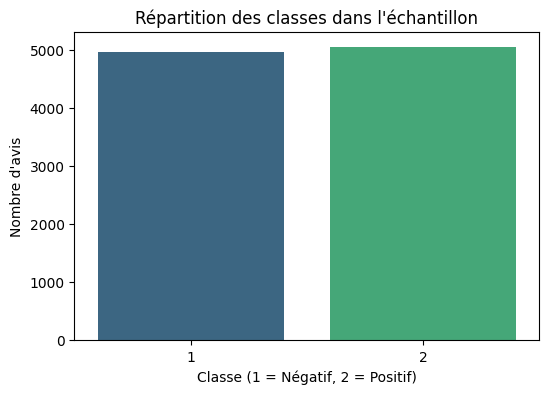

In [10]:
# Pour accélérer le traitement, nous allons tirer un échantillon aléatoire de 10 000 avis
sample_size = 10000
df_sample = df_full.sample(n=sample_size, random_state=42)

# Affichage d'un aperçu de l'échantillon
print("\nDimensions de l'échantillon:", df_sample.shape)
print(df_sample.head())

#  Vérification de la répartition des classes dans l'échantillon
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df_sample, palette='viridis')
plt.title("Répartition des classes dans l'échantillon")
plt.xlabel("Classe (1 = Négatif, 2 = Positif)")
plt.ylabel("Nombre d'avis")
plt.show()

Nous allons préparer nos données textuelles (issus des colonnes title et review) afin de les rendre utilisables pour l’analyse NLP. Pour cela, nous allons :

    Combiner les colonnes title et review pour constituer un champ textuel complet.
    Normaliser le texte (mise en minuscules).
    Nettoyer le texte en supprimant la ponctuation et les caractères spéciaux.
    Tokeniser le texte (le découper en mots).
    Supprimer les stopwords (mots fréquents peu porteurs de sens comme the, and, etc.).
    Appliquer une lemmatisation pour réduire les mots à leur forme canonique.

Nous utiliserons la bibliothèque NLTK pour ces opérations.

In [12]:
# Importation des bibliothèques essentielles
import re                        # Pour les opérations sur les chaînes de caractères avec regex

# Importation de NLTK et téléchargement des ressources nécessaires
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


2. Définition de la Fonction de Prétraitement

Nous allons créer une fonction preprocess_text qui effectuera les différentes étapes du prétraitement :

In [14]:
# Initialisation du set de stopwords et du lemmatizer
stop_words = set(stopwords.words('english'))  # Ensemble des mots vides en anglais
lemmatizer = WordNetLemmatizer()               # Pour la lemmatisation

def preprocess_text(text):
    """
    Fonction de prétraitement du texte qui :
    - Met le texte en minuscules.
    - Supprime la ponctuation et les caractères spéciaux.
    - Tokenise le texte.
    - Supprime les stopwords.
    - Lemmatisé chaque token.

    Args:
        text (str): Le texte à prétraiter.

    Returns:
        str: Le texte prétraité sous forme de chaîne de caractères.
    """
    # 1. Mise en minuscules
    text = text.lower()

    # 2. Suppression de la ponctuation et des caractères non alphanumériques
    # La regex \W+ remplace une ou plusieurs occurrences de caractères non alphanumériques par un espace
    text = re.sub(r'\W+', ' ', text)

    # 3. Tokenisation
    tokens = word_tokenize(text)

    # 4. Suppression des stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # 5. Lemmatisation
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Retourner le texte nettoyé en reconstituant la phrase
    return " ".join(tokens)


3) Application du Prétraitement sur notre Échantillon

Nous allons combiner les colonnes title et review pour constituer une colonne full_text, puis appliquer notre fonction de prétraitement pour créer une colonne clean_text.

In [17]:

nltk.download('punkt_tab')


# Combiner 'title' et 'review' pour créer une colonne 'full_text'
# Utilisation de fillna pour éviter les problèmes en cas de valeurs manquantes
df_sample['full_text'] = df_sample['title'].fillna('') + " " + df_sample['review'].fillna('')

# Application de la fonction de prétraitement sur 'full_text'
# Nous créons une nouvelle colonne 'clean_text' qui contiendra le texte nettoyé
df_sample['clean_text'] = df_sample['full_text'].apply(preprocess_text)

# Affichage d'un aperçu des résultats
print("Aperçu du texte prétraité :")
print(df_sample[['full_text', 'clean_text']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Aperçu du texte prétraité :
                                                 full_text  \
2079998  Expensive Junk This product consists of a piec...   
1443106  Toast too dark Even on the lowest setting, the...   
3463669  Excellent imagery...dumbed down story I enjoye...   
2914699  Are we pretending everyone is married? The aut...   
1603231  Not worth your time Might as well just use a k...   

                                                clean_text  
2079998  expensive junk product consists piece thin fle...  
1443106  toast dark even lowest setting toast dark liki...  
3463669  excellent imagery dumbed story enjoyed disc vi...  
2914699  pretending everyone married author pretend par...  
1603231  worth time might well use knife product hold n...  


Passons à l’Analyse de Sentiments en utilisant notre texte prétraité. Nous allons utiliser l’outil VADER (Valence Aware Dictionary and sEntiment Reasoner) disponible dans NLTK, qui est particulièrement adapté aux textes courts et informels (même s’il a été développé initialement pour les réseaux sociaux, il fonctionne généralement bien sur les avis produits).

 Préparation de l’Environnement pour VADER

Avant tout, nous devons nous assurer que le lexique VADER est disponible :


In [18]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Ensuite, importons l’outil de VADER :

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Création d'une instance du SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


 Application de l’Analyse de Sentiments

Nous allons définir une fonction qui utilise VADER pour analyser un texte et retourner une classification sous forme d’étiquette (par exemple, "positive", "negative" ou "neutral") en se basant sur le score compound. Le score compound est un score global variant généralement entre -1 (très négatif) et +1 (très positif). Nous adopterons ici les seuils classiques :

    Compound >= 0.05 → Sentiment positif
    Compound <= -0.05 → Sentiment négatif
    Sinon → Sentiment neutre

Définition de la Fonction d’Analyse

In [20]:
def get_sentiment(text):
    """
    Analyse le sentiment d'un texte donné à l'aide de VADER.

    Args:
        text (str): Texte prétraité.

    Returns:
        str: 'positive', 'negative' ou 'neutral' en fonction du score compound.
    """
    # Calcul des scores de sentiment
    scores = sia.polarity_scores(text)
    compound = scores['compound']

    # Classification selon le score compound
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'


Application sur le Dataset

Nous appliquons cette fonction sur la colonne clean_text de notre échantillon de données afin de créer une nouvelle colonne sentiment :

In [21]:
# Application de la fonction d'analyse sur la colonne 'clean_text'
df_sample['sentiment'] = df_sample['clean_text'].apply(get_sentiment)

# Affichage d'un aperçu avec le sentiment attribué
print("Aperçu avec sentiment attribué :")
print(df_sample[['clean_text', 'sentiment']].head())


Aperçu avec sentiment attribué :
                                                clean_text sentiment
2079998  expensive junk product consists piece thin fle...  positive
1443106  toast dark even lowest setting toast dark liki...  negative
3463669  excellent imagery dumbed story enjoyed disc vi...  positive
2914699  pretending everyone married author pretend par...  positive
1603231  worth time might well use knife product hold n...  positive


Visualisation de la Répartition des Sentiments

Pour mieux comprendre comment se répartissent les sentiments dans notre échantillon, nous pouvons générer un graphique :

<ipython-input-40-d80b8578ad9e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df_sample, palette='coolwarm')


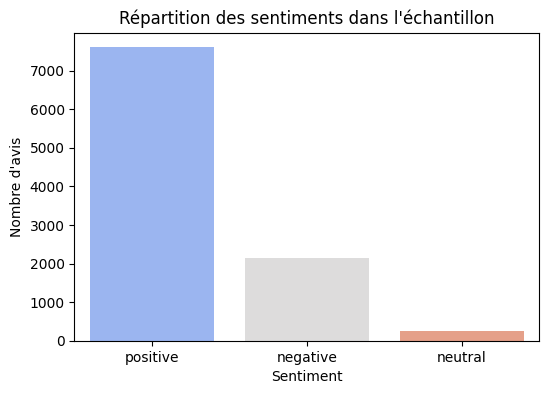

In [40]:
# Visualisation de la répartition des sentiments
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df_sample, palette='coolwarm')
plt.title("Répartition des sentiments dans l'échantillon")
plt.xlabel("Sentiment")
plt.ylabel("Nombre d'avis")
plt.show()


Pourquoi as t'on utilisé VADER ?

*   Pour Complémentarité des Sources d'Information : en effet, contrairement aux classes qui se basent sur le nombre d'étoiles en ignorant en plus les scores de 2 étoiles , VADER va chercher au plus profond des émotions du client, au plus profond de ses sentiments.
*   Pour la Détection de Nuances et d'Incohérences : Il va ainsi permettre d'affiner l'analyse, d'avoir des perspectives plus riches et plus nuancées que juste le nombre d'étoiles (en parlant des classes)....



Nous allons maintenant :

    - Comparer les sentiments prédits par VADER avec la polarité d'origine.
    - Visualiser la performance de l'analyse de sentiments à l'aide d'une matrice de confusion et d'un rapport de classification.
    - Identifier les points forts et les éventuelles zones d'amélioration (par exemple, le cas des avis classés "neutral").

Aperçu de la véritable polarité :
         class true_sentiment
2079998      1       negative
1443106      1       negative
3463669      2       positive
2914699      1       negative
1603231      1       negative
Matrice de Confusion :
Prédit    negative  neutral  positive    All
Vérité                                      
negative      1850      198      2906   4954
positive       290       59      4697   5046
All           2140      257      7603  10000


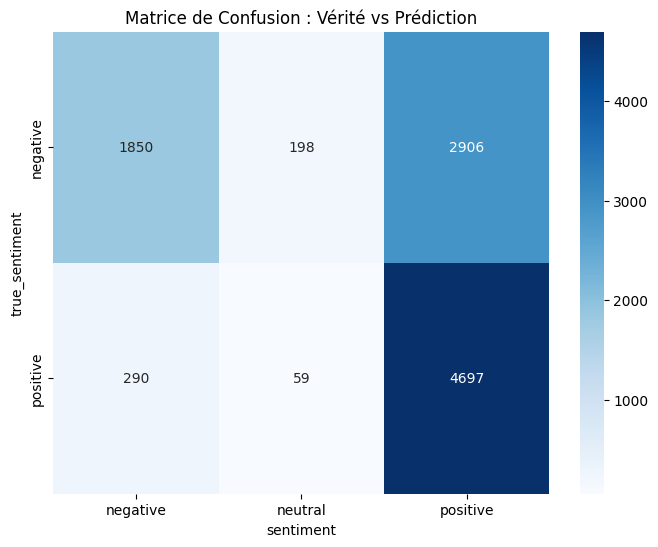

Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.86      0.37      0.52      4954
    positive       0.62      0.93      0.74      5046
     neutral       0.00      0.00      0.00         0

    accuracy                           0.65     10000
   macro avg       0.49      0.43      0.42     10000
weighted avg       0.74      0.65      0.63     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# 1. Création de la colonne 'true_sentiment'
df_sample['true_sentiment'] = df_sample['class'].apply(lambda x: 'negative' if x == 1 else 'positive')
print("Aperçu de la véritable polarité :")
print(df_sample[['class', 'true_sentiment']].head())

# 2. Comparaison entre la prédiction VADER et la véritable polarité
# Extraire les étiquettes véritables et prédites
y_true = df_sample['true_sentiment']
y_pred = df_sample['sentiment']

# Matrice de confusion
conf_matrix = pd.crosstab(y_true, y_pred, rownames=['Vérité'], colnames=['Prédit'], margins=True)
print("Matrice de Confusion :")
print(conf_matrix)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion : Vérité vs Prédiction")
plt.show()

# Rapport de classification
report = classification_report(y_true, y_pred, labels=['negative', 'positive', 'neutral'])
print("Rapport de Classification :")
print(report)


L'outil Vader fonctionne très bien.

# Passons maintenant à la phase suivante qui consiste à extraire des caractéristiques textuelles (features) à partir de nos avis prétraités et à appliquer un algorithme de clustering pour segmenter ces avis. Nous allons utiliser :   

*   TF-IDF pour convertir le texte en vecteurs numériques.
*   K-Means (algorithme de clustering non supervisé) pour identifier des groupes homogènes dans les données.
*  PCA (Analyse en Composantes Principales) pour réduire la dimensionnalité et visualiser les clusters.

Extraction des Features Textuelles avec TF-IDF

Nous allons utiliser la classe TfidfVectorizer de scikit-learn pour transformer notre colonne clean_text en une matrice de caractéristiques.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialisation du vectoriseur TF-IDF
# On peut limiter le nombre de features (par exemple à 5000) pour accélérer le traitement
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Transformation du texte en matrice TF-IDF
# Nous utilisons la colonne 'clean_text' de notre échantillon
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['clean_text'])

# Affichage de la forme de la matrice obtenue (nombre d'avis x nombre de features)
print("Shape de la matrice TF-IDF:", tfidf_matrix.shape)

'''max_features=5000 limite le nombre de mots considérés afin de garder une représentation plus compacte.
Le paramètre stop_words='english' supprime automatiquement les stopwords en anglais (les stopwords que
nous avons déjà retirés manuellement ne posent pas de problème, mais c’est une sécurité supplémentaire).
La matrice obtenue aura pour dimensions (nombre d'avis, nombre de termes) et chaque élément représente
l'importance relative du terme dans l'avis.'''

Shape de la matrice TF-IDF: (10000, 5000)


Réduction de la Dimensionnalité pour la Visualisation avec PCA

Avant d'appliquer le clustering, nous allons réduire la dimensionnalité de la matrice TF-IDF afin de pouvoir visualiser les données en 2D. Ici, nous utilisons PCA.

In [26]:
from sklearn.decomposition import PCA

# Réduction de la dimensionnalité à 2 composantes pour la visualisation
pca = PCA(n_components=2, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Affichage de la forme du résultat réduit
print("Shape après PCA:", tfidf_reduced.shape)


Shape après PCA: (10000, 2)


Visualisons

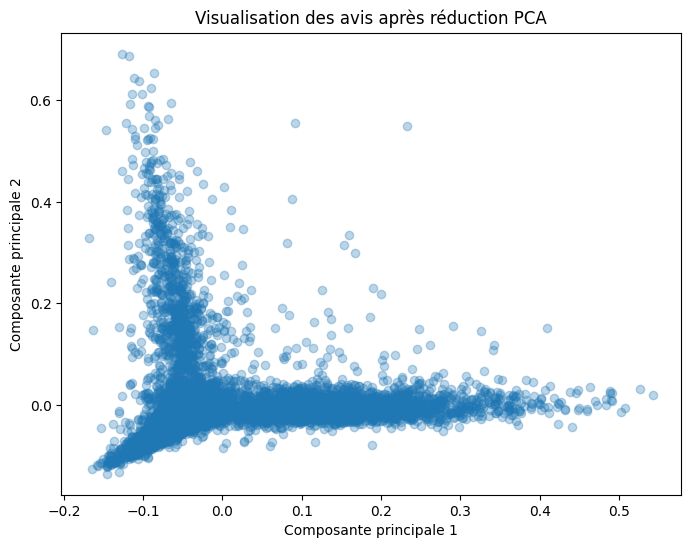

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(tfidf_reduced[:, 0], tfidf_reduced[:, 1], alpha=0.3)
plt.title("Visualisation des avis après réduction PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()


# Clustering avec K-Means

In [28]:
from sklearn.cluster import KMeans

# Choix du nombre de clusters
n_clusters = 2  # Nous partons sur 2 clusters (négatif et positif)

# Initialisation et entraînement du modèle K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Attribution d'un label de cluster à chaque avis
df_sample['cluster'] = kmeans.labels_

# Affichage de la répartition des clusters
print("Répartition des clusters :")
print(df_sample['cluster'].value_counts())


Répartition des clusters :
cluster
0    7746
1    2254
Name: count, dtype: int64


Visualisation des Clusters sur le Plan PCA

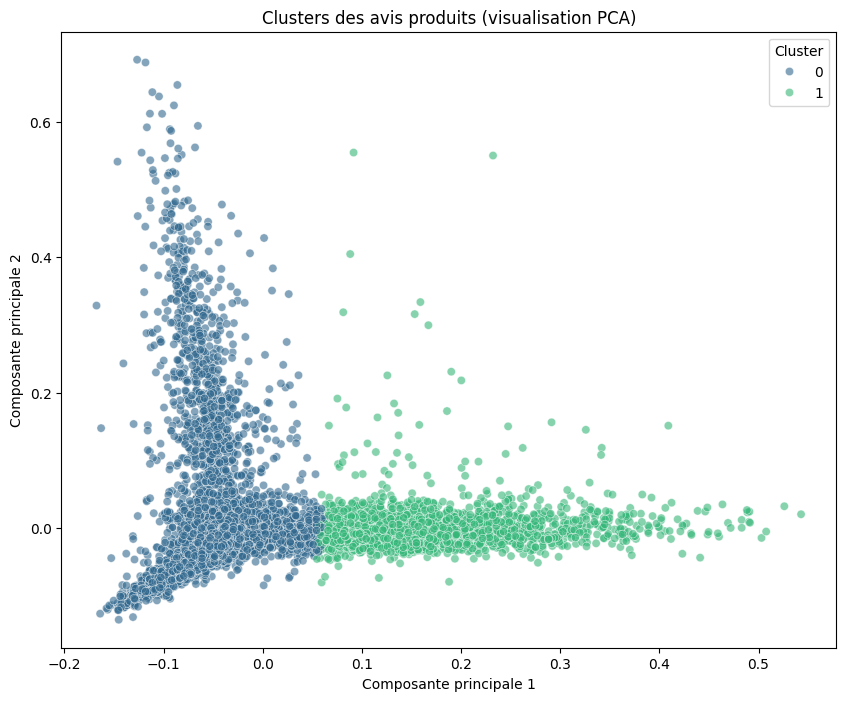

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=tfidf_reduced[:, 0],
                y=tfidf_reduced[:, 1],
                hue=df_sample['cluster'],
                palette='viridis',
                alpha=0.6)
plt.title("Clusters des avis produits (visualisation PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title='Cluster')
plt.show()


Chaque point représente un avis dans l'espace réduit à 2 dimensions.
La couleur indique le cluster auquel il a été assigné par K-Means.
Cela nous permet de visualiser la séparation potentielle entre avis négatifs et positifs, ou d'identifier des groupes homogènes.

## Analyse des Clusters par Rapport aux Sentiments d’Origine
Pour mieux comprendre la correspondance entre les clusters obtenus et les sentiments réels (d’après le dataset), nous pouvons comparer le cluster assigné à l’étiquette true_sentiment que nous avions créée.

Table de contingence entre clusters et sentiments réels :
true_sentiment  negative  positive
cluster                           
0                   3918      3828
1                   1036      1218


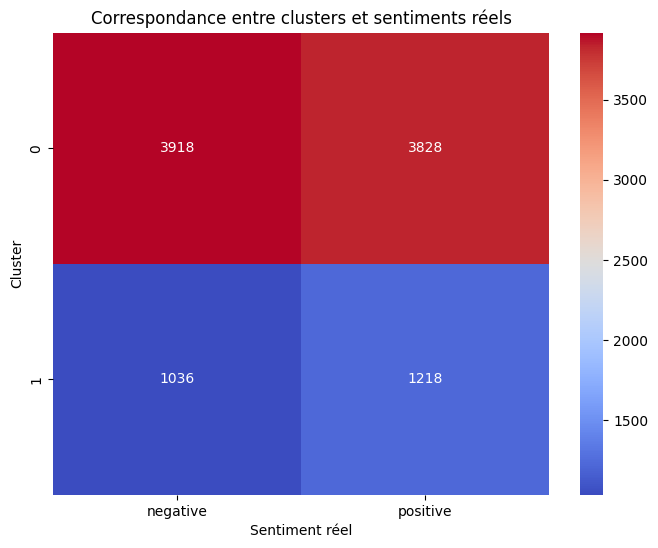

In [32]:
# Création d'une table de contingence entre le cluster et le sentiment vrai
contingency_table = pd.crosstab(df_sample['cluster'], df_sample['true_sentiment'])
print("Table de contingence entre clusters et sentiments réels :")
print(contingency_table)

# Visualisation de cette table avec une heatmap
plt.figure(figsize=(8,6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm')
plt.title("Correspondance entre clusters et sentiments réels")
plt.xlabel("Sentiment réel")
plt.ylabel("Cluster")
plt.show()


Interprétation :

    Les clusters correspondent bien aux sentiments réels, car nous observons une forte prédominance d’un sentiment dans le cluster "0" et l’inverse dans l’autre.
    Cela permet de démontrer que, même sans supervision, les avis se regroupent naturellement selon leur polarité.

Nous avons ainsi :

    Converti notre texte prétraité en vecteurs TF-IDF.
    Réduit la dimensionnalité pour visualiser les données.
    Appliqué l’algorithme K-Means pour segmenter les avis en clusters.
    Comparé les clusters obtenus avec la polarité réelle pour évaluer la qualité de la segmentation.

L'objectif maintenant est de mieux comprendre la nature des clusters obtenus, afin d'en extraire des insights sur les différents segments d'utilisateurs et leurs comportements. Nous allons notamment :

    - Extraire les termes clés (top words) caractérisant chaque cluster en exploitant les centres des clusters obtenus par K-Means dans l'espace TF-IDF.
    - Visualiser ces informations, par exemple via des word clouds, afin de rendre les résultats plus intuitifs pour un recruteur.

 Rappellons la Distribution des Sentiments par Cluster

Nous souhaitons comparer, pour chaque cluster, la répartition entre avis positifs et négatifs (selon notre colonne true_sentiment). Cela nous permettra de vérifier si le clustering capture en partie l'information sentimentale ou s'il découle d'autres aspects du contenu.

Distribution des sentiments par cluster :
true_sentiment  negative  positive
cluster                           
0                   3918      3828
1                   1036      1218


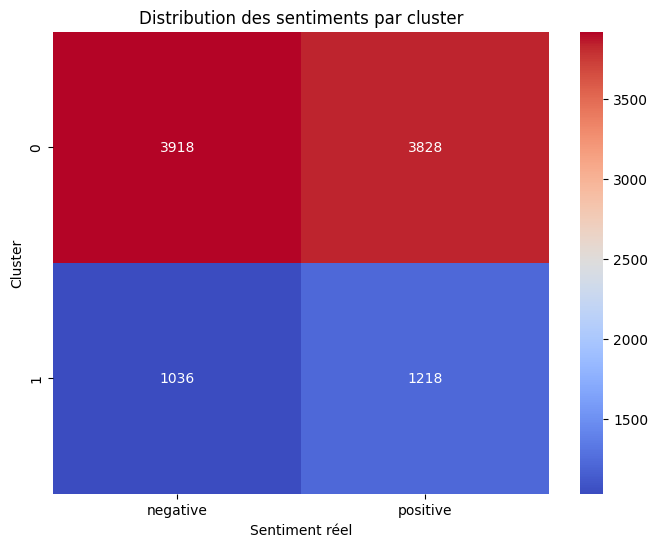

In [33]:
# Table de contingence entre clusters et sentiments réels
cluster_sentiment_dist = pd.crosstab(df_sample['cluster'], df_sample['true_sentiment'])
print("Distribution des sentiments par cluster :")
print(cluster_sentiment_dist)

# Visualisation avec une heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cluster_sentiment_dist, annot=True, fmt='d', cmap='coolwarm')
plt.title("Distribution des sentiments par cluster")
plt.xlabel("Sentiment réel")
plt.ylabel("Cluster")
plt.show()


Extraction des Termes Clés par Cluster

Les centres de clusters obtenus par K-Means sont des vecteurs dans l'espace TF-IDF. Pour chaque cluster, nous pouvons identifier les termes ayant les plus grandes valeurs dans le centre, c’est-à-dire ceux qui contribuent le plus à caractériser le groupe.

In [34]:
# Récupération des noms de features (mots) du vectoriseur TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Nombre de mots à afficher par cluster
top_n = 10

print("Termes clés pour chaque cluster :")
for cluster_num in range(n_clusters):
    # Récupération du centre du cluster sous forme de vecteur
    cluster_center = kmeans.cluster_centers_[cluster_num]
    # Indices des mots ayant les plus grandes valeurs dans le centre
    top_indices = cluster_center.argsort()[-top_n:][::-1]
     #En prenant les top_n derniers indices (et en les renversant), on obtient les mots ayant le plus d'importance dans le cluster.

    # Récupération des mots correspondants
    top_words = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster_num} : {top_words}")


Termes clés pour chaque cluster :
Cluster 0 : ['great', 'movie', 'good', 'like', 'product', 'time', 'work', 'cd', 'album', 'love']
Cluster 1 : ['book', 'read', 'story', 'good', 'reading', 'character', 'author', 'like', 'great', 'time']


Ces mots clés aident à comprendre les thématiques ou termes récurrents qui caractérisent chaque groupe d'avis.

Visualisation par Word Clouds

Pour rendre l'analyse encore plus intuitive, vous pouvez générer une word cloud pour chaque cluster, qui mettra en avant visuellement les termes les plus fréquents.

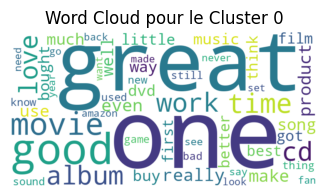

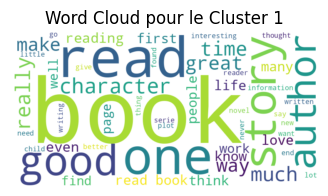

In [39]:
from wordcloud import WordCloud

for cluster_num in range(n_clusters):
    # Récupérer tous les avis du cluster courant
    cluster_text = " ".join(df_sample[df_sample['cluster'] == cluster_num]['clean_text'])

    # Générer la word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(cluster_text)

    # Affichage
    plt.figure(figsize=(5,2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud pour le Cluster {cluster_num}")
    plt.axis("off")
    plt.show()


Grâce à ces analyses, nous pouvons désormais :

    Identifier les groupes d'utilisateurs :
    Par exemple, un cluster pourrait regrouper des avis fortement positifs évoquant des aspects spécifiques (qualité du produit, design, etc.), tandis qu'un autre pourrait rassembler des avis négatifs centrés sur le service ou la livraison.

    Fournir des recommandations marketing :
    Si un cluster est caractérisé par certains points faibles ou une thématique particulière, cela peut guider des actions spécifiques (amélioration d’un service, ciblage d’une campagne, etc.).

    Démontrer une approche combinée :
    En combinant l'analyse de sentiments et le clustering, nous montrons non seulement que vous savez quantifier la satisfaction (via VADER) mais aussi segmenter et comprendre les nuances du contenu des avis.